In [1]:
#!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-02-ESTADISTICA/master/init.py
#import init; init.init(force_download=False); 
from IPython.display import Image

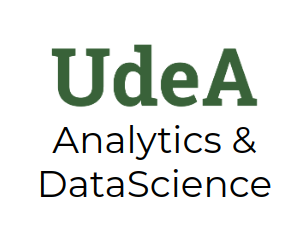

In [2]:
Image('../docs/udea-datascience.png')

**Desarrollado por:** Javier Fernando Botía Valderrama

*Docente del Departamento de Ingeniería de Sistemas*

**Materia:** Estadística y Análisis Exploratorio

**Departamento:** Posgrado en Ingeniería

**Facultad de Ingeniería - Universidad de Antioquia**

# Análisis de Datos para Clasificación de Datos

In [3]:
#!pip install pingouin

     ------------------------------------ 198.6/198.6 KB 430.0 kB/s eta 0:00:00
     -------------------------------------- 981.2/981.2 KB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7054 sha256=7b3993bdb3d11e5dec56a0222f548afac18f0117bcb3fd3802d32bfcfa12fc04
  Stored in directory: c:\users\mdmgu\appdata\local\pip\cache\wheels\04\bb\0d\2d02ec45f29c48d6192476bfb59c5a0e64b605e7212374dd15
Successfully built littleutils


You should consider upgrading via the 'C:\Users\mdmgu\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import io
import requests
import seaborn as sns
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind # t-test de dos muestras independientes
import pingouin as pg # Librería para realizar test estadísticos

from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bayes
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Usando Test Estadístico para Analizar un Conjunto de Datos para la Clasificación de Datos

The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1). The class distribution is 3,818 samples in class 0 and 1,586 samples in class 1.

The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water.

https://sci2s.ugr.es/keel/dataset.php?cod=105

In [6]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/phoneme.dat"
download = requests.get(url).content
data = pd.read_table(
    io.StringIO(download.decode('utf-8')), 
    sep=',',
    decimal=',')

data.head()

,Aa,Ao,Dcl,Iy,Sh,Class
0,1.24,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.3,1.041,0.559,0
3,0.279,0.99,2.555,-0.738,0.0,0
4,0.307,1.272,2.656,-0.946,-0.467,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Aa      5404 non-null   object
 1    Ao     5404 non-null   object
 2    Dcl    5404 non-null   object
 3    Iy     5404 non-null   object
 4    Sh     5404 non-null   object
 5    Class  5404 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 253.4+ KB


In [8]:
data = data.values
data = pd.DataFrame(data, columns = ['Aa', 'Ao', 'Dcl', 'Iy', 'Sh', 'Class'])

In [9]:
data['Class'] = data['Class'].replace(0, 'No')
data['Class'] = data['Class'].replace(1, 'Yes')

In [10]:
display(data)

,Aa,Ao,Dcl,Iy,Sh,Class
0,1.24,0.875,-0.205,-0.078,0.067,No
1,0.268,1.352,1.035,-0.332,0.217,No
2,1.567,0.867,1.3,1.041,0.559,No
3,0.279,0.99,2.555,-0.738,0.0,No
4,0.307,1.272,2.656,-0.946,-0.467,No
...,...,...,...,...,...,...
5399,0.254,2.392,0.689,1.828,-0.544,No
5400,0.781,1.25,0.793,0.383,0.816,Yes
5401,1.031,0.584,1.866,1.532,-0.671,Yes
5402,0.15,0.933,2.363,-0.742,-0.617,No


La anterior base de datos tiene datos cuantitativos y datos cualitativos. Para realizar un análisis de datos cuantitativos y cualitativos, uno de los test estadísticos más famosos es el **test T-student**.

## Test T-student

En el test T, se analiza como las muestras se pueden modelar desde una población de distribución normal (Gaussiana) y como **la desviación estandar muestral se puede estimar como una varianza poblacional**, lo cual la distribución de las medias muestrales para una variable $x$ se puede determinar como:

$$t = \frac{\bar{x}-\mu}{(s/\sqrt{N})}$$

donde $\bar{x}$ es la media de una muestra de datos, $\mu$ es la media poblacional, $s$ es la desviación estándar poblacional y $N$ es el tamaño de las muestras de los datos.

Considerando la anterior ecuación, la prueba t se puede usar para comparar la media de una muestra con respecto a una población con una media conocida. Para este caso, la *hipótesis nula* esta establecida como no hay diferencias significativas entre la media en la población desde el cual la muestra esta definida y la media de la población conocida.

### Test T- student de una muestra

la ecuación del **test t de una muestra** se expresa como:

$$t = \frac{\bar{x}-\mu_0}{(s_0/\sqrt{N})}$$

donde $\bar{x}$ es la media de la muestra, $\mu_0$ es la media de referencia que se conoce, $s_0$ es la desviación estándar de la muestra y $N$ es el tamaño de la muestra.

*   $H_0$ = No hay diferencias entre la media conocida de los datos y la media calculada por una determinada distribución de densidad de probabilidad ($\mu_1 = \mu_2$)
*   $H_A$ = Hay diferencias entre la media conocida de los datos y la media calculada por una determinada distribución de densidad de probabilidad. En este caso, el valor real de la media poblacional de los datos suele ser mayor o menor al valor de la media que establece $H_0$ (es decir, $\mu_1 \neq \mu_2$)

In [11]:
data_cuantitativo = data[['Aa',	'Ao',	'Dcl',	'Iy',	'Sh']]
data_cuantitativo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Aa      5404 non-null   object
 1   Ao      5404 non-null   object
 2   Dcl     5404 non-null   object
 3   Iy      5404 non-null   object
 4   Sh      5404 non-null   object
dtypes: object(5)
memory usage: 211.2+ KB


In [12]:
data_cuantitativo = data_cuantitativo.astype('float')

In [18]:
t_test = []
valor_p = []
Caracteristicas = data_cuantitativo.columns
nombres = ['norm', 'expon', 'chi2', 't', 'cauchy', 'beta'] 
Data_muestra = data_cuantitativo[: 50] # 50 Muestras

# cauchy = distribución de densidad de probabilidad Cauchy
# chi2 = distribución de densidad de probabilidad chi - cuadrada
# expon = función de densidad de probabilidad exponencial
# norm = función de densidad de probabilidad normal
# beta = función de densidad de probabilidad beta 

for distribuciones in nombres:
    dis = getattr(scipy.stats, distribuciones)
    for n in Caracteristicas:
        A = np.asarray(Data_muestra[n])
        par = dis.fit(A)
        if distribuciones == 'norm' or 'expon' or 'cauchy':
            media = par[0]
        elif distribuciones == 'chi2' or 't':
            media = par[1]
        elif distribuciones == 'beta':
            media = par[2]
        valor_t_test, p_value = ttest_1samp(Data_muestra[n], media, alternative='two-sided') # test _t de 1 muestra poblacional
        valor_p.append(p_value)
        t_test.append(valor_t_test)

valor_p = np.asarray(valor_p)
valor_p = valor_p.reshape(len(nombres), len(Caracteristicas))
t_test = np.asarray(t_test)
t_test = t_test.reshape(len(nombres), len(Caracteristicas))

t_test = pd.DataFrame(t_test, index=nombres, columns=Caracteristicas)
valor_p = pd.DataFrame(valor_p, index=nombres, columns=Caracteristicas)

display(t_test)
print('\n')
display(valor_p)

C:\Users\mdmgu\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_continuous_distns.py:684: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


,Aa,Ao,Dcl,Iy,Sh
norm,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
expon,6.645623,1.444023e+01,1.036833e+01,1.202274e+01,11.784036
chi2,-9.406894,-6.164188e+02,-3.368741e+00,-1.662658e+01,-141.071509
t,-8.265916,-4.470318e+07,-4.421065e+07,-5.907278e+07,-16.687206
cauchy,2.666066,1.310502e+00,7.110385e-01,1.222781e+00,1.828293
beta,2.767698,-5.259789e+00,8.750459e-01,-1.202868e+01,-67.704356


,Aa,Ao,Dcl,Iy,Sh
norm,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
expon,2.349117e-08,2.775935e-19,5.976180e-14,3.153221e-16,6.576005e-16
chi2,1.471988e-12,5.743385e-97,1.478203e-03,8.764522e-22,1.306927e-65
t,7.513087e-11,0.000000e+00,0.000000e+00,0.000000e+00,7.527854e-22
cauchy,1.036681e-02,1.961356e-01,4.804315e-01,2.272612e-01,7.359643e-02
beta,7.944607e-03,3.155618e-06,3.858181e-01,3.096324e-16,4.500886e-50


*Nota*: en el test t de una muestra, hay una opción llamada `alternative`. Se puede trabajar de tres formas de acuerdo a la hipótesis nula y alternativa:

*   Si `alternative = 'two-sided'`, entonces se quiere demostrar la diferencia del valor de hipótesis nula (la opción que estamos analizando)
*   Si `alternative = 'greater'`, entonces se quiere demostrar que la media muestral de los datos es mayor que una media dada de la población $\mu_1 > \mu_2$
*   Si `alternative = 'lower'`, entonces se quiere demostrar que la media muestral de los datos es menor que una media dada de la población $\mu_1 < \mu_2$

Observen que el test t con una selección de las primeras 50 muestras nos indica que el valor $p$ esta por encima de 0.05 para el caso de la distribución normal. Por consiguiente, no rechazamos la hipótesis nula de la prueba debido a que no tenemos pruebas suficientes para afirmar que la media conocida de los datos y la media calculada por una determinada distribución de densidad de probabilidad sean diferentes. Por consiguiente, las 5 características o variables siguen una distribución normal.

In [19]:
from scipy.stats import norm # distribución de densidad de probabilidad normal

par_Aa, par_Ao, par_Dc1, par_Iy, par_Sh  = [
    norm.fit(data_cuantitativo['Aa']), 
    norm.fit(data_cuantitativo['Ao']), 
    norm.fit(data_cuantitativo['Dcl']),
    norm.fit(data_cuantitativo['Iy']), 
    norm.fit(data_cuantitativo['Sh'])
]

par = [par_Aa, par_Ao, par_Dc1, par_Iy, par_Sh]
par = pd.DataFrame(np.asarray(par).T, columns=Caracteristicas)
par
# A partir de los datos, calculamos los parámetros de ajuste de la distribución usando la Estimación de la Máxima Verosimilitud (MLE)

,Aa,Ao,Dcl,Iy,Sh
0,0.818957,1.258802,0.764732,0.398743,0.078619
1,0.858654,0.850979,0.925351,0.796457,0.575571


In [20]:
parametro = par[n].values
parametro[1]

0.5755709556653462

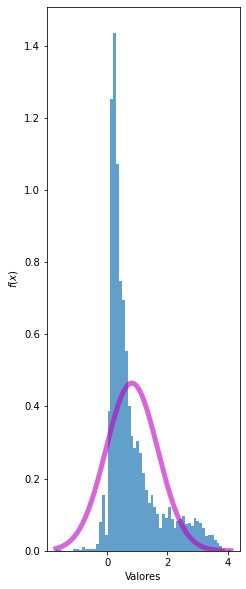

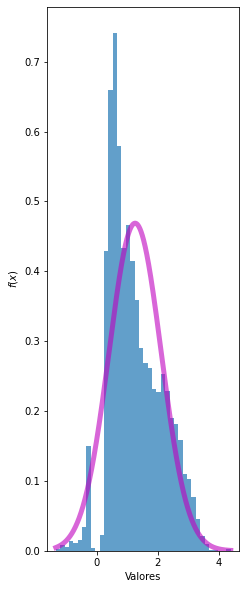

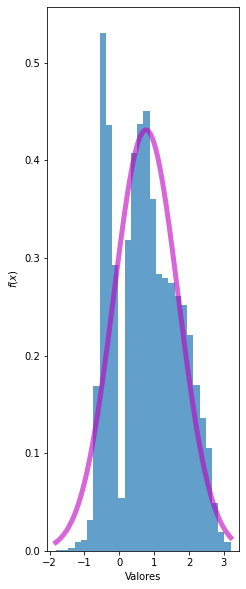

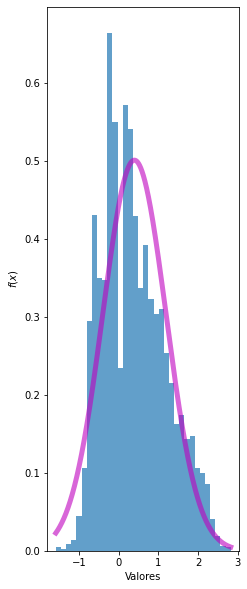

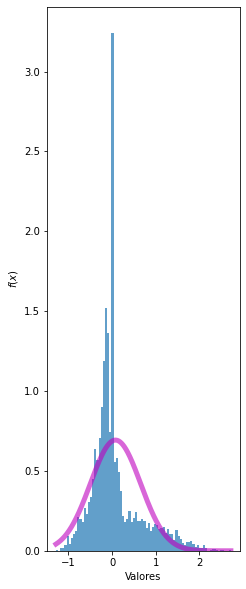

In [24]:
k = 0

for n in Caracteristicas:
    x_minimo = np.min(data_cuantitativo[n].values)
    x_maximo = np.max(data_cuantitativo[n].values)
    x = np.linspace(x_minimo, x_maximo, data_cuantitativo[n].shape[0]) 
    # Generamos un arreglo de valores para construir la función de densidad de probabilidad normal
    parametro = par[n].values
    norm_dist = norm.pdf(x, loc = parametro[0], scale = parametro[1])
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, data_cuantitativo.shape[1], k + 1)
    plt.hist(data_cuantitativo[n], density=True, bins = 'fd', alpha=0.7)
    plt.plot(x, norm_dist, 'm-', lw = 5, alpha = 0.6)
    plt.xlabel('Valores')
    plt.ylabel('$f(x)$')

Otro ejemplo de análisis con el test t de una sola muestra:

Considerando la variable *Sh* o She, esta variable representa la intensidad de la voz de una mujer cuando repite la palabra She. Queremos determinar si la intensidad de la voz tiene una media igual a 0.01 para una muestra de 50 medidas de la voz. A partir de lo anterior, vamos a considerar dos hipótesis:

H0: µ = 15 (the mean height for this species of plant is 15 inches)

*   $H_0$: $\mu = 0.01$ significa que la media de la intensidad de la voz de la mujer es igual a 0.01
*   $H_A$: $\mu \neq 0.01$ significa que la media de la intensidad de la voz de la mujer **no es igual** a 0.01


In [25]:
Muestra = Data_muestra['Sh']
media_pop = 0.01
valor_T, p_value = ttest_1samp(Muestra, media_pop)
print("Valor del test t = ", valor_T)
print("Valor p del test t = ", p_value)

Valor del test t =  0.2917173106451872
Valor p del test t =  0.7717342492897488


Debido a que el $\rho$-value de 0.77173 es mayor a $\alpha = 0.05$, no se rechaza la hipótesis nula y por consiguiente, no hay suficiente evidencia para afirmar que la media de la intensidad de la voz de la mujer es diferente a 0.01. Esto quiere decir que la media de la muestra de los datos es igual a 0.01

### Test-T para muestras independientes

Hasta el momento, solo se ha analizado con una sola variable pero qué sucede si tenemos dos muestras independientes?. Para resolver esta inquietud, se establece el **test t de dos muestras o muestras independientes**. El proposito de ese test es determinar si las medias de las poblaciones de las que se extrajeron las muestras son iguales. Para este caso, se supone que las dos muestras no están relacionados entre sí y que han sido seleccionados independientemente de sus poblaciones. Además, suponemos que las poblaciones de las que se seleccionaron las muestras tienen una distribución normal o Gaussiana, al menos que las muestras sean suficientemente grandes para invocar el teorema del límite central, y que las poblaciones tienen una varianza aproximadamente igual. 

Basado en el anterior enfoque del test t, se determina que:

$$t = \frac{(\bar{x_1}-\bar{x_2}) - (\mu_1 - \mu_2)}{\sqrt{s_p^2 \left( \frac{1}{N_1}+\frac{1}{N_2} \right)}}$$

donde:

$$s_p^2 = \frac{(n_1 - 1)s_1^2 + (n_1 - 1)s_2^2}{N_1 + N_2 - 2}$$

siendo $\bar{x_1}$ y $\bar{x_2}$ dos medias de dos muestras independientes, $\mu_1$ y $\mu_2$ son las medias de dos poblaciones, $s_p^2$ es la varianza acumulada, $s_1^2$ y $s_2^2$ son las varianzas de dos muestras y $N_1$ y $N_2$ son dos tamaños de dos muestras.

Con la anterior explicación, vamos a utilizar los datos de la variable `Class` para determinar inicialmente si sigue o no una distribución normal:


*   $H_0$: No hay diferencia entre las medias poblacionales, $\mu_{Class: No} = \mu_{Class: Yes}$
*   $H_1$: Si hay diferencia entre las medias poblacionales, $\mu_{Class: No} \neq \mu_{Class: Yes}$

In [26]:
data_nuevo = pd.concat([data_cuantitativo, data['Class']], axis = 1)
data_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Aa      5404 non-null   float64
 1   Ao      5404 non-null   float64
 2   Dcl     5404 non-null   float64
 3   Iy      5404 non-null   float64
 4   Sh      5404 non-null   float64
 5   Class   5404 non-null   object 
dtypes: float64(5), object(1)
memory usage: 253.4+ KB


In [27]:
data_nuevo.groupby('Class').size()

Class
No     3818
Yes    1586
dtype: int64

In [28]:
pg.normality(data = data_nuevo, dv='Aa', group='Class')

,W,pval,normal
Class,,,
No,0.860836,0.000000e+00,False
Yes,0.930665,1.699995e-26,False


In [29]:
pg.normality(data = data_nuevo, dv='Ao', group='Class')

,W,pval,normal
Class,,,
No,0.982307,1.869817e-21,False
Yes,0.874562,6.514833e-34,False


In [30]:
pg.normality(data = data_nuevo, dv='Dcl', group='Class')

,W,pval,normal
Class,,,
No,0.942722,3.940932e-36,False
Yes,0.974421,3.431056e-16,False


In [31]:
pg.normality(data = data_nuevo, dv='Iy', group='Class')

,W,pval,normal
Class,,,
No,0.942222,2.965070e-36,False
Yes,0.943520,3.730205e-24,False


In [32]:
pg.normality(data = data_nuevo, dv='Sh', group='Class')

,W,pval,normal
Class,,,
No,0.835144,0.000000e+00,False
Yes,0.949034,5.026160e-23,False


In [38]:
# Mismos pasos en un ciclo for (johan)
for col in data_nuevo.columns[:-1]:
    df = pg.normality(data = data_nuevo, dv=col, group='Class')
    display(df)

,W,pval,normal
Class,,,
No,0.860836,0.000000e+00,False
Yes,0.930665,1.699995e-26,False


,W,pval,normal
Class,,,
No,0.982307,1.869817e-21,False
Yes,0.874562,6.514833e-34,False


,W,pval,normal
Class,,,
No,0.942722,3.940932e-36,False
Yes,0.974421,3.431056e-16,False


,W,pval,normal
Class,,,
No,0.942222,2.965070e-36,False
Yes,0.943520,3.730205e-24,False


,W,pval,normal
Class,,,
No,0.835144,0.000000e+00,False
Yes,0.949034,5.026160e-23,False


El anterior test para determinar si una variable cuantitativa con respecto a una variable cualitativa siguen o no una distribución normal se llama el **test Shapiro-Wilk**. En todas las pruebas, se observa que los datos **no vienen** de poblaciones con distribución normal. Dado que la comparación entre variables cuantitativas con respecto a la variable cualitativa no procede de una población con distribución normal, se recomienda usar **comparar las varianzas** usando un **test de Levene**. Veamos como se realiza este procedimiento con nuestros datos:

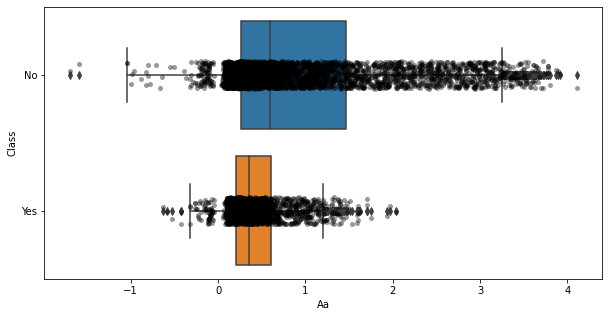

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(
    y="Class", 
    x="Aa", 
    data=data_nuevo, 
    ax=ax)
sns.stripplot(
    y="Class", 
    x="Aa", 
    data = data_nuevo, 
    color = 'black', 
    alpha = 0.4, 
    ax = ax)
plt.show()

In [40]:
pg.homoscedasticity(data = data_nuevo, dv = 'Aa', group ='Class')

,W,pval,equal_var
levene,544.41112,8.343761e-115,False


**Nota**: la homocedasticidad o varianza entre poblaciones permite establecer si dos varianzas son iguales o no.

In [41]:
pg.homoscedasticity(data = data_nuevo, dv = 'Ao', group ='Class')

,W,pval,equal_var
levene,380.352863,6.469768e-82,False


In [42]:
pg.homoscedasticity(data = data_nuevo, dv = 'Dcl', group ='Class')

,W,pval,equal_var
levene,140.233821,5.863704e-32,False


In [43]:
pg.homoscedasticity(data = data_nuevo, dv = 'Iy', group ='Class')

,W,pval,equal_var
levene,102.935781,5.671396e-24,False


In [44]:
pg.homoscedasticity(data = data_nuevo, dv = 'Sh', group ='Class')

,W,pval,equal_var
levene,810.549092,3.058114e-166,False


Como en todas las pruebas de Levene mencionan que la igualdad de la varianza es falsa, entonces se debe aplicar el t-test para muestras independientes con la corrección de Welch que permite compensar la diferencia entre varianza. En caso que si existiera igualdad de la varianza, se puede aplicar el test t para muestras independientes sin necesidad de esta corrección.

In [54]:
nombres = data_nuevo.columns
nombres = nombres.drop('Class')
Resultado= []

for n in nombres:
    comparacion_1 = data_nuevo.loc[data_nuevo.Class == 'No', n]
    comparacion_2 = data_nuevo.loc[data_nuevo.Class == 'Yes', n]
    Tabla = pg.ttest(x = comparacion_1, y = comparacion_2, alternative='two-sided', correction = True)
    Resultado.append(Tabla)

In [55]:
Resultado[0] # Aa vs Class

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,29.451105,5352.503806,two-sided,8.090088e-177,"[0.49, 0.56]",0.636567,6.694e+172,1.0


In [56]:
Resultado[1] # Ao vs Class

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,19.904657,4055.626981,two-sided,3.440199e-84,"[0.39, 0.47]",0.52145,2.164e+81,1.0


In [57]:
Resultado[2] # Dcl vs Class

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-25.50145,3751.529133,two-sided,1.996532e-132,"[-0.66, -0.56]",0.689345,3.631e+131,1.0


In [58]:
Resultado[3] # ly vs Class

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-23.5571,2471.305113,two-sided,7.304893e-111,"[-0.63, -0.53]",0.77006,9.07e+112,1.0


In [59]:
Resultado[4] # Sh vs Class

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-8.82951,2047.846446,two-sided,2.208493e-18,"[-0.23, -0.14]",0.324171,1.913e+15,1.0


Ya que el valor $\rho$ es menor a 0.05, se dispone de evidencia suficiente para considerar que existe una diferencia real entre las variables cuantitativas cuando se etiqueta en la clase *No* y *Yes*. Por consiguiente, rechazamos la hipótesis nula en favor de la hipótesis alternativa.


## Selección de características o variables con el test chi-cuadrado

Primero separamos los datos en características, el cual llamaremos **X**, y en el vector de clases, el cual llamaremos **Y**

In [60]:
data.columns

Index(['Aa', 'Ao', 'Dcl', 'Iy', 'Sh', 'Class'], dtype='object')

In [61]:
X = data[['Aa', 'Ao', 'Dcl', 'Iy', 'Sh']] # Características
Y = data['Class'] # Vector de clases

Considerando que en este escenario el test Chi-Cuadrada esta restringuido a los valores enteros o flotantes positivos, se debe analizar con la función `describe()` Si hay valores negativos en las características:

In [62]:
X = X.astype(float)

In [63]:
X.describe()

,Aa,Ao,Dcl,Iy,Sh
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.818957,1.258802,0.764732,0.398743,0.078619
std,0.858733,0.851057,0.925436,0.796531,0.575624
min,-1.700000,-1.327000,-1.823000,-1.581000,-1.284000
25%,0.243750,0.596000,-0.115000,-0.205000,-0.232250
50%,0.492500,1.075500,0.729000,0.285500,-0.044000
75%,1.089250,1.866250,1.484000,0.937000,0.196250
max,4.107000,4.378000,3.199000,2.826000,2.719000


Como los valores mínimos de cada variable son negativos, se requiere normalizar **X** para tener solo valores positivos:

In [64]:
MM = MinMaxScaler()
X_norm = MM.fit_transform(X)
X_norm = pd.DataFrame(X_norm, columns = X.columns)

Una vez realizado este procedimiento, se aplica el test chi-cuadrada entre `X_Norm` y `Y`

In [65]:
Chi_Value, value_p = chi2(X_norm, Y)
Tabla = pd.DataFrame(np.vstack([Chi_Value, value_p]).T, columns = ['Chi valor', 'value-p'])
Tabla_concatenada = pd.concat([pd.DataFrame(X.columns, columns = ['Caracteristica']), Tabla], axis = 1)
Tabla_concatenada

,Caracteristica,Chi valor,value-p
0,Aa,21.119604,4.314913e-06
1,Ao,14.163367,1.676021e-04
2,Dcl,31.948210,1.583382e-08
3,Iy,43.035369,5.375914e-11
4,Sh,7.001730,8.143100e-03


Considerando el valor p obtenido por cada característica, todos los casos muestran que $p \leq 0.05$. Este resultado indica que las variables son dependientes del vector de clases de la base de datos. No obstante, se puede analizar los valores de la prueba chi-cuadrada para determinar independencia o dependencia entre variables a partir del vector de clases, si se considera las siguientes hipótesis:

*   $H_0$: Dos caracteristicas son independientes del vector de clases. 
*   $H_A$: Dos caracteristicas son dependientes del vector de clases.

Este último caso, $H_A$, es el más útil para crear posteriormente un modelo de clasificación de datos. Usualmente, para que se cumpla dicha condición, el valor Chi-cuadrada debe ser el más grande para demostrar que es estadísticamente suficiente para seleccionar las dos características más relevantes para crear un modelo de clasificación de datos eficiente.

Veamos como se realiza dicho proceso:

In [72]:
Modelo_Seleccion_Chi_Cuadrada = SelectKBest(chi2, k=2) # k = 2 es el número de características para seleccionar si los valores Chi-Cudrada
                                                         # son los más grandes comparado con otros valores.

In [73]:
X_Norm_Seleccionado = Modelo_Seleccion_Chi_Cuadrada.fit_transform(X_norm, Y)
X_Norm_Seleccionado.shape

(5404, 2)

Para determinar cúales son las características seleccionadas, se puede comparar entre las medias de los datos originales y las medias de los datos seleccionados:

In [74]:
Media_Original = X_norm.mean()
Media_Seleccionados = pd.DataFrame(X_Norm_Seleccionado).mean()
Medias_Caracteristicas_Seleccionadas = []

for a in range(len(Media_Seleccionados)):
    pos = Media_Original.loc[Media_Original == Media_Seleccionados[a]]
    Medias_Caracteristicas_Seleccionadas.append(pos)

Medias_Caracteristicas_Seleccionadas = pd.DataFrame(Medias_Caracteristicas_Seleccionadas)
Caracteristicas_Seleccionadas = Medias_Caracteristicas_Seleccionadas.columns
print("Características seleccionadas = ", Caracteristicas_Seleccionadas)

Características seleccionadas =  Index(['Dcl', 'Iy'], dtype='object')


Con las características seleccionadas, se genera una nueva base de datos con las características que son estadísticamente más significativos de acuerdo al test chi-cuadrada.

In [75]:
X_seleccionado = X[['Dcl', 'Iy']]
display(X_seleccionado)

,Dcl,Iy
0,-0.205,-0.078
1,1.035,-0.332
2,1.300,1.041
3,2.555,-0.738
4,2.656,-0.946
...,...,...
5399,0.689,1.828
5400,0.793,0.383
5401,1.866,1.532
5402,2.363,-0.742


Aunque se realizó dicha selección de datos, cómo se podría verificar si dichas características son los más representativos para un modelo de clasificación de datos? Aquí les muestro una de las estrategías:

1) Generamos una partición de los datos en entrenamiento y en prueba, tanto para los datos normalizados originales como para los datos normalizados con las características seleccionadas

In [76]:
X_norm_train, X_norm_test, y_1_train, y_1_test = train_test_split(X_norm, Y, train_size=0.7) # 0.7 es el 70% de los datos son para
                                                                                               # crear el modelo de clasificación de datos
                                                                                               # el 30% restante son los datos para realizar
                                                                                               # una validación del modelo.

X_norm_selected_train, X_norm_selected_test, y_2_train, y_2_test = train_test_split(X_Norm_Seleccionado, Y, train_size=0.7) 
                                                                                               # 0.7 es el 70% de los datos son para
                                                                                               # crear el modelo de clasificación de datos
                                                                                               # el 30% restante son los datos para realizar
                                                                                               # una validación del modelo. 

2) Creamos los modelos de clasificación de datos

In [77]:
GNB_1 = GaussianNB() # Algoritmo Bayes Ingenuo Gaussiano para clasificar datos
GNB_2 = GaussianNB()

GNB_1.fit(X_norm_train, y_1_train)
GNB_2.fit(X_norm_selected_train, y_2_train)

GaussianNB()

3) Realizamos una predicción de las clases con los datos de prueba y posteriormente, se calcula la exactitud de la clasificación comparando con el vector de clases para la validación

In [78]:
Y_pred_all_features = GNB_1.predict(X_norm_test)
Y_pred_selected_features = GNB_2.predict(X_norm_selected_test)

print("Exactitud de la clasificación con todas las características = {:.3f} %".format(100*accuracy_score(y_1_test,Y_pred_all_features)))
print("Exactitud de la clasificación con las características seleccionadas = {:.3f} %".format(100*accuracy_score(y_2_test,Y_pred_selected_features)))

Exactitud de la clasificación con todas las características = 76.079 %
Exactitud de la clasificación con las características seleccionadas = 72.195 %


Observen que la diferencia de la exactitud para ambos casos es mayor al 2 %, lo cual la clasificación con las características seleccionadas tiene un desempeño mejor con respecto al caso de todas las características. Lo anterior es el principio de la **importancia de las características**, el cual permite establecer cuales son las características que realmente aporta más información a la clasificación de datos. 

### Selección de características o variables con ANOVA (Análisis de Varianzas)

#### ANOVA

El análisis ANOVA o análisis de varianza es un modelo que permite evaluar la influencia de dos o más variables independientes con respecto a una variable dependiente, por medio de un **test de diferencias entre varianzas** (e inclusive entre medias). Tales diferencias se comparan en término de una métrica del error que es atribuible a una variación en las variables dependientes dentro una condición que permite saber que proporción de la variación de una variable dependiente puede atribuirse a la manipulación de las variables de un experimento, de un sistema real, etc. 

Veamos la siguiente base de datos del número de visitas de cuatro páginas web:

In [79]:
Paginas = np.array([[164, 178, 175, 155], [172, 191, 193, 166], [177, 182, 171, 164],
                    [156, 185, 163, 170], [195, 177, 176, 168]])

Paginas = pd.DataFrame(Paginas, columns = ['Web 1', 'Web 2', 'Web 3', 'Web 4'])
display(Paginas)

,Web 1,Web 2,Web 3,Web 4
0,164,178,175,155
1,172,191,193,166
2,177,182,171,164
3,156,185,163,170
4,195,177,176,168


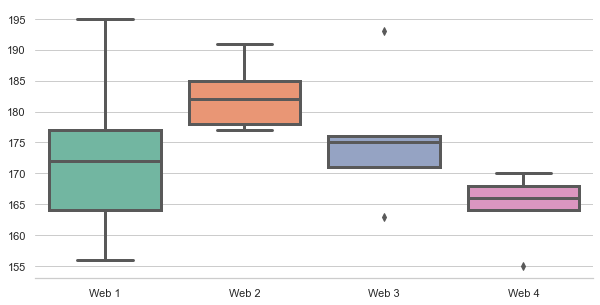

In [95]:
sns.set(rc={'figure.figsize':(10, 5)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = Paginas, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [96]:
Nombres = np.array(['Web 1', 'Web 2', 'Web 3', 'Web 4'])
Nombres_repetidos = numpy.matlib.repmat(Nombres,1,Paginas.shape[0])

In [97]:
datos_paginas = Paginas.values.reshape(1,Paginas.shape[0]*Paginas.shape[1])

In [100]:
datos_pagina_concatenados = pd.concat(
    [pd.DataFrame(Nombres_repetidos.T, columns=['Pagina']),
     pd.DataFrame(datos_paginas.T, columns=['Tiempo'])], 
    axis=1)

In [101]:
datos_pagina_concatenados

,Pagina,Tiempo
0,Web 1,164
1,Web 2,178
2,Web 3,175
3,Web 4,155
4,Web 1,172
5,Web 2,191
6,Web 3,193
7,Web 4,166
8,Web 1,177
9,Web 2,182


In [102]:
datos_agrupados = datos_pagina_concatenados.groupby('Pagina')

A partir del agrupamiento de los datos con `groupby`, el test ANOVA se realiza un procedimiento con remuestreo de datos para facilitar la comparación entre las cuatro variables de la base de datos. En este caso, vamos a mezclar y extraer cuatro remuestreos de cinco valores cada uno. Luego, calculamos la media de cada una de las cuatro variables o características y posteriormente, calculamos la varianza observada en cada una. Finalmente, repetimos este proceso varias veces hasta encontrar un valor de prueba `Pr(Prob)` que podamos comparar con el valor p de referencia de 0.05

In [103]:
Varianza_Observada = datos_agrupados.mean().var()[0]
print("Medias observadas de la base de datos: ", datos_agrupados.mean().values.ravel())
print("Varianza Observada: ", Varianza_Observada)

Medias observadas de la base de datos:  [172.8 182.6 175.6 164.6]
Varianza Observada:  55.426666666666655


Para el remuestreo, realizamos una prueba de permutación exhaustiva, el cual nos permite descubrir todas las formas posibles en que podemos dividir y mezclar los datos de forma aleatoria. Con la cantidad de repeticiones que generemos, es probable que nos permita acercanos o alejarnos de un intervalo de confianza p de 0.05. 

**Nota:** Esta estrategía es válida si el tamaño de los datos es pequeño. Para datos de mayor tamaño, la permutación basado en boostrap sería lo más recomendable.

In [105]:
def test_permutaciones(data):
    data = data.copy()
    data['Tiempo'] = np.random.permutation(data['Tiempo'].values)
    return data.groupby('Pagina').mean().var()[0]

In [88]:
permutaciones_varianza = [test_permutaciones(datos_pagina_concatenados) for _ in range(3000)] # repetimos el proceso 3000 veces
print("Pr(Prob)", np.mean([var > Varianza_Observada for var in permutaciones_varianza]))

Pr(Prob) 0.07733333333333334


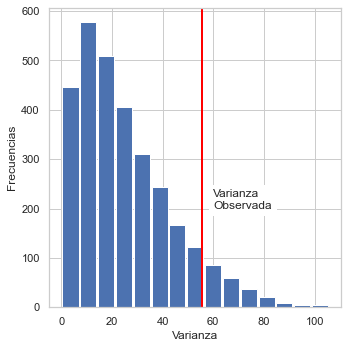

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(permutaciones_varianza, bins = 15, rwidth = 0.9)
ax.axvline(x = Varianza_Observada, color='red', lw=2)
ax.text(60, 200, 'Varianza\nObservada', bbox={'facecolor':'white'})
ax.set_xlabel('Varianza')
ax.set_ylabel('Frecuencias')

plt.tight_layout()
plt.show()

El valor p del test ANOVA nos genero un valor de 0.074, lo cual es mayor al valor p tradicional de 0.05. Esto significa que la diferencia entre las cuatro variables se generaron por casualidad o coincidencia.

#### F- Measure

F-Measure o el estadístico F permite reemplazar la prueba de permutación del ANOVA por un test estadístico basado en la razón entre la varianza de las medias de un grupo de datos y la varianza generada por el error residual de los datos. Si el valor de este test es mayor, más significativo estadísticamente será el resultado del análisis.



*Descripción complementaria del estadístico F para ANOVA*:

El análisis ANOVA básico se define matemáticamente a partir de un parámetro llamado **número de niveles**, $p$, tal que $y_{k,l}$ es el valor observable definido como una variable dependiente (función de pronóstico):

$$y_{k,l} = \mu + \alpha_l + \epsilon_{k,l}$$

donde:

*   $\mu$ es un valor constante que representa el punto de corte con el eje $y$. 
*   $l$ es la etiqueta en el cual indica el nivel del factor, siendo $l = \lbrace 1,\ldots, p \rbrace$
*   $k$ es la $k$-enésima prueba o test, siendo $k = \lbrace 1, \ldots, n_l\rbrace$ y $n_l$ es el número de tratamientos o pruebas para un nivel de factor $l$.
*   $\alpha_l$ es el efecto del $l$-enésimo nivel que varia la prueba o tratamiento.  
*   $\epsilon_{k,l}$ es una variable independiente y aleatoria que adiciona un margen de error entre un valor predicho y un valor conocido u observable. 

Si $\epsilon_{k,l} = 0$ entonces $l = 0$ y por consiguiente se obtiene una función de pronóstico llamado **media de la prueba o tratamiento:**

$$y_{k} = \mu + \alpha_l$$

Si $y_{k,l} = y_k + \epsilon_{k,l}$, donde asumimos que los valores predichos de $y_{k,l}$ tendrá un margen de error $\epsilon_{k,l}$, se puede afirmar que la ecuación $y_{k} = \mu + \alpha_l$ se puede reescribir como:

$$y_{k,l} -\epsilon_{k,l} = y_k + \epsilon_{k,l} - \hat{y}$$

donde $\hat{y}$ es la media general de los valores predichos. Como ANOVA analiza variaciones de varianza, se puede escribir la anterior ecuación como:

$$\sum_k \sum_l (y_{k,l} -\hat{y})^2 = \sum_k \sum_l (y_{k,l} - y_k)^2 + N\sum_k (y_{k} - \hat{y})^2$$

donde:

*   $S_{r} = N\sum_k (y_{k} - \hat{y})^2$ es una métrica que mide la variación debida *al nivel de factor* (error de regresión de cuadrados).
*   $S_{e} = \sum_k \sum_l (y_{k,l} - y_k)^2$ es una métrica que relaciona la varianza dentro de *cada* factor (error de cuadrados).

De esta manera, la **varianza total**, $S_{t} = S_{r} + S_{e}$. A partir de $S{r}$ y $S_{e}$, se puede establecer varias medidas que nos permitirá analizar si se acepta o no una hipótesis nula. Una de las medidas es el **F-distribución**, dado por una razón entre $S{r}$ y $S_{e}$:

$$F_{distribucion} = \frac{S_{r}/(p - 1)}{S_{e}/(n_{l} - p)}$$

Si $F_{distribucion}$ es un valor grande, entonces hay mayor probabilidad que se acepte la hipótesis nula. Para encontrar $p_{value}$ que permite aceptar o rechazar la hipótesis nula, se puede usar la métrica $F_{distribucion}$ con $p-1$ y $n_{l} - 1$. 

In [90]:
Modelo_OLS = smf.ols('Tiempo ~ Pagina', data = datos_pagina_concatenados).fit()
# Creamos un modelo de regresión de mínimo cuadrados ordinarios

In [91]:
Tabla = sm.stats.anova_lm(Modelo_OLS)
print(Tabla)

            df  sum_sq     mean_sq         F    PR(>F)
Pagina     3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


`sum_sq` es la suma de cuadrados, `mean_sq` es cuadrados medios o desviaciones cuadráticas medias, `F` es el estadístico F, `df` es el grado de libertas y `PR(>F)` es el valor p estimados por ANOVA F-estadístico.

Para el promedio general, la suma de cuadrados es la desviación del promedio general, al cuadrado, multiplicado por un número de observaciones, que por defecto, son 20.

El número de grados de libertad por defecto es 1.0 pero al realizar el análisis, el grado de libertad aumentó a 3.0. Lo anterior se debe a que para las medias del tratamiento, una vez se establecen tres valores y luego se establece el promedio general, la otra media del tratamiento no puede variar. En el caso de la suma de los cuadrados de las medias del tratamiento es la suma de las desviaciones al cuadrado entre las medias del tratamiento y el promedio general. 

En el caso de los residuos, hay 16 grados de libertad, de los cuales en 20 observaciones, hay 16 observaciones que pueden variar después que se genere la media general y las medias del tratamiento.

SS es la suma de las diferencia al cuadrado entre las observaciones individuales de los datos y las medias del tratamiento.

Los cuadrados medios o desviaciones cuadráticas medias es la suma de los cuadrados dividida por los grados de libertad.

Por tanto, el estadístico F sería la razón entre los cuadrados medios para las medias del tratamiento y los cuadrados medios del error.

Considerando lo anterior, estamos trabajando ANOVA unidireccional o *one way*, el cual se tiene un factor o grupo que varía. Veamos como se podría implementar:

In [116]:
import scipy
analisis = scipy.stats.f_oneway(datos_pagina_concatenados[datos_pagina_concatenados.Pagina == 'Web 1'].Tiempo, 
                     datos_pagina_concatenados[datos_pagina_concatenados.Pagina == 'Web 2'].Tiempo,
                     datos_pagina_concatenados[datos_pagina_concatenados.Pagina == 'Web 3'].Tiempo,
                     datos_pagina_concatenados[datos_pagina_concatenados.Pagina == 'Web 4'].Tiempo)
print(f'F-Statistic: {analisis.statistic:.4f}')
print(f'p-value: {analisis.pvalue:.4f}')

F-Statistic: 2.7398
p-value: 0.0776


Considerando `F-Statistic` y `p-value`, no hay diferencias estadísticamente significativos entre las variables y por consiguiente, la diferencia entre las cuatro variables se generaron por casualidad o coincidencia. 






#### Selección de características con ANOVA F-Measure

In [117]:
F_estadistica, value_p = f_classif(X_norm, Y)
Tabla = pd.DataFrame(np.vstack([F_estadistica, value_p]).T, columns = ['F_estadistica', 'value-p'])
Tabla_concatenada = pd.concat([pd.DataFrame(X.columns, columns = ['Caracteristica']), Tabla], axis = 1)
Tabla_concatenada

,Caracteristica,F_estadistica,value-p
0,Aa,454.059232,8.270064e-97
1,Ao,304.683234,2.031720e-66
2,Dcl,532.471563,1.920298e-112
3,Iy,664.465922,2.726775e-138
4,Sh,117.752969,3.736565e-27


In [118]:
Modelo_Seleccion_F_Estadistica = SelectKBest(f_classif, k = 2) # k = 2 es el número de características para seleccionar si los valores Chi-Cudrada
                                                         # son los más grandes comparado con otros valores.

In [119]:
X_Norm_Seleccionado = Modelo_Seleccion_F_Estadistica.fit_transform(X_norm, Y)
X_Norm_Seleccionado.shape

(5404, 2)

In [120]:
Media_Original = X_norm.mean()
Media_Seleccionados = pd.DataFrame(X_Norm_Seleccionado).mean()
Medias_Caracteristicas_Seleccionadas = []

for a in range(len(Media_Seleccionados)):
    pos = Media_Original.loc[Media_Original == Media_Seleccionados[a]]
    Medias_Caracteristicas_Seleccionadas.append(pos)

Medias_Caracteristicas_Seleccionadas = pd.DataFrame(Medias_Caracteristicas_Seleccionadas)
Caracteristicas_Seleccionadas = Medias_Caracteristicas_Seleccionadas.columns
print("Características seleccionadas = ", Caracteristicas_Seleccionadas)

Características seleccionadas =  Index(['Dcl', 'Iy'], dtype='object')


In [122]:
X_seleccionado = X[['Dcl', 'Iy']]
display(X_seleccionado)

,Dcl,Iy
0,-0.205,-0.078
1,1.035,-0.332
2,1.300,1.041
3,2.555,-0.738
4,2.656,-0.946
...,...,...
5399,0.689,1.828
5400,0.793,0.383
5401,1.866,1.532
5402,2.363,-0.742


## Usando Medidas de Entropía para Analizar un Conjunto de Datos para la Clasificación de Datos

Considerando la importancia de las métricas de entropía para medir la cantidad de información de un conjunto de datos, se puede adaptar la entropía de Shannon para tareas de selección de variables o características, usando la teoría de la **información mutua** que se vio en la sesión 3_3 --> información mutua para datos categóricos. 

La **información mutua** permite medir la dependencia entre las variables o características pero se estima con distancias de vecinos más cercanos para evitar hasta lo posible la reducción de la varianza. Cuando el valor de la entropía es 0, las variables son independientes, y un valor de entropía cercano a 1, hay una alta dependencia entre las variables.

In [108]:
seleccion = mutual_info_classif(X_norm, Y, discrete_features = 'auto', n_neighbors = 3)

**NOTA:** Al incrementar el número de vecinos, se logra reducir la varianza durante la estimación de la entropía relativa pero hay riesgos de aumentar el sesgo si el número de muestras o filas de la base de datos es grande.

In [109]:
Tabla_concatenada = pd.concat([pd.DataFrame(X.columns, columns = ['Caracteristica']), 
                               pd.DataFrame(seleccion, columns = ['Cantidad de Información'])], 
                              axis = 1)
Tabla_concatenada

,Caracteristica,Cantidad de Información
0,Aa,0.093388
1,Ao,0.076791
2,Dcl,0.119754
3,Iy,0.176389
4,Sh,0.139993


In [111]:
data_seleccionado_Norm = X_norm[['Dcl', 'Iy', 'Sh']]

In [112]:
X_norm_selected_train, X_norm_selected_test, y_2_train, y_2_test = train_test_split(data_seleccionado_Norm, Y, train_size = 0.7) 
                                                                                               # 0.7 es el 70% de los datos son para
                                                                                               # crear el modelo de clasificación de datos
                                                                                               # el 30% restante son los datos para realizar
                                                                                               # una validación del modelo. 

In [113]:
GNB_1 = GaussianNB() # Algoritmo Bayes Ingenuo Gaussiano para clasificar datos
GNB_2 = GaussianNB()

GNB_1.fit(X_norm_train, y_1_train)
GNB_2.fit(X_norm_selected_train, y_2_train)

GaussianNB()

In [114]:
Y_pred_all_features = GNB_1.predict(X_norm_test)
Y_pred_selected_features = GNB_2.predict(X_norm_selected_test)

print("Exactitud de la clasificación con todas las características = {:.3f} %".format(100*accuracy_score(y_1_test,Y_pred_all_features)))
print("Exactitud de la clasificación con las características seleccionadas = {:.3f} %".format(100*accuracy_score(y_2_test,Y_pred_selected_features)))

Exactitud de la clasificación con todas las características = 76.079 %
Exactitud de la clasificación con las características seleccionadas = 74.599 %


Observen que en este escenario, la selección de las características realizado permitío aumentar la exactitud de la clasificación de los datos en 1 % aproximadamente.